In [7]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from utils import load_house_data, plot_housing_prices, animate_neural_network

sizes, prices, labels = load_house_data('data/housing_prices.txt')

# As before, we load the housing data and scale it
size_scaled = (sizes - np.mean(sizes)) / np.std(sizes)
price_scaled = (prices - np.mean(prices)) / np.std(prices)

# Create feature list: [size, price, size^2, price^2]
features = [
    size_scaled,      # Feature 0: size
    price_scaled,     # Feature 1: price
]

# Convert to numpy array for easier computation
feature_matrix = np.array(features).T  # Shape: (n_samples, n_features)
feature_names = ['size', 'price']

In [8]:
def sigmoid(z):
    """Sigmoid activation function"""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    ####### YOUR CODE HERE #######
    s = sigmoid(z)
    ds = sigmoid(z)*(1-sigmoid(z))
    ###### END OF YOUR CODE ######
    return ds

np.random.seed(42) 
class SimpleNeuralNetwork:
    """A simple 2-layer neural network for binary classification"""
    
    def __init__(self, input_size=2, hidden_size=6, output_size=1, activation='sigmoid'):
        """
        Initialize the neural network
        
        Parameters:
        - input_size: number of input features
        - hidden_size: number of neurons in hidden layer
        - output_size: number of output neurons (1 for binary classification)
        - activation: 'sigmoid' or 'relu' for hidden layer activation
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        
        # Initialize weights randomly and and biases as zeros

        ####### YOUR CODE HERE #######
        # Hidden layer weights: (input_size, hidden_size)
        # Xavier Initalisation np.sqrt(2/(input_size,hidden_size))
        self.W1 = np.random.randn(input_size,hidden_size)* np.sqrt(2.0 / (input_size + hidden_size))
        self.b1 = 1
        
        # Output layer weights: (hidden_size, output_size)
        self.W2 =  np.random.randn(hidden_size,output_size) * np.sqrt(2.0 / (output_size + hidden_size))
        self.b2 = 1
        ###### END OF YOUR CODE ######
        
        # Choose activation function
        self.activation_func = sigmoid
        self.activation_derivative = sigmoid_derivative
        
        # Store training history
        self.loss_history = []
        self.weights_history = {'W1': [], 'b1': [], 'W2': [], 'b2': []}

    
    def forward_pass(self, X):
        """
        Perform forward propagation through the network
        
        Parameters:
        - X: input features (n_samples, n_features)
        
        Returns:
        - A2: output predictions
        - cache: intermediate values for backpropagation
        """
        ##### YOUR CODE HERE #####
        # Layer 1: Hidden layer
        # Linear transformation: Z1 = X @ W1 + b1
     #   print("shape of X ", X.shape, " w1 shape ", self.W1.shape)
        Z1 = X @ self.W1 + self.b1  # Shape: (n_samples, hidden_size)
      #  print("shape of Z1 (n_samples, hidden_size) ", Z1.shape)
        # Apply activation function
        A1 = sigmoid(Z1)    # Shape: (n_samples, hidden_size)
      #  print("shape of A1 (n_samples, hidden_size) ", A1.shape)
        # Layer 2: Output layer
        # Linear transformation: Z2 = A1 @ W2 + b2
        Z2 = A1 @ self.W2 + self.b2 # Shape: (n_samples, output_size)
        
     #   print("shape of Z2 (n_samples, output_size) ", Z2.shape)
        # Apply sigmoid for binary classification
        A2 = sigmoid(Z2)                  # Shape: (n_samples, output_size)
      #  print("shape of A2 (n_samples, output_size) ", A2.shape)
        ######### END OF YOUR CODE ######
        
        # Store intermediate values for backpropagation
        cache = {
            'X': X,
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
        
        return A2, cache
    
    def calculate_loss(self, y_true, y_pred):
        """Calculate binary cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def backward_pass(self, cache, y_true):
        """
        Perform backpropagation to calculate gradients
        
        Parameters:
        - cache: intermediate values from forward pass
        - y_true: true labels
        
        Returns:
        - gradients: dictionary containing all gradients
        """
        # Retrieve cached values
        ####### YOUR CODE HERE #######
        X, Z1, A1, Z2, A2 = cache['X'] , cache['Z1'], cache['A1'],cache['Z2'], cache['A2']
        m = X.shape[0]  # number of samples

        #print("Shape of m ", m)
        
        # Output layer gradients
        # dL/dZ2 = A2 - y_true (derivative of sigmoid + cross-entropy)
        # reshape y_true to match A2 shape via y_true.reshape(-1, 1)
       # print(f"Shape of A2 {A2.shape}")
        y_true = y_true.reshape(-1,1)
        dZ2 = A2 - y_true  # Shape: (n_samples, 1)

       # print("Shape of dZ2 ", dZ2.shape)
        
        # dL/dW2 = A1.T @ dZ2 / m
        dW2 =  (A1.T@dZ2)/len(X)  # Shape: (hidden_size, 1)
        
        # dL/db2 = mean(dZ2) (over the first axis and keep dimensions)
        db2 = np.mean(dZ2)  # Shape: (1, 1)
        
        # Hidden layer gradients
        # dL/dA1 = dZ2 @ W2.T
        dA1 =  dZ2@self.W2.T    # Shape: (n_samples, hidden_size)
        
        # dL/dZ1 = dA1 * activation_derivative(Z1)
        dZ1 = dA1 * sigmoid_derivative(Z1)  # Shape: (n_samples, hidden_size)
        
        # dL/dW1 = X.T @ dZ1 / m
        dW1 = (X.T @ dZ1) /len(X)      # Shape: (input_size, hidden_size)
        
        # dL/db1 = mean(dZ1) (over the first axis and keep dimensions)
        db1 = np.mean(dZ1)  # Shape: (1, hidden_size)
        ######### END OF YOUR CODE ######
        
        gradients = {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }
        
        return gradients
    

    def update_parameters(self, gradients, learning_rate):
        """Update network parameters using gradients"""
        self.W1 -= learning_rate * gradients['dW1']
        self.b1 -= learning_rate * gradients['db1']
        self.W2 -= learning_rate * gradients['dW2']
        self.b2 -= learning_rate * gradients['db2']

    def predict(self, X):
        """Get prediction probabilities"""
        y_pred, _ = self.forward_pass(X)
        return y_pred.flatten()    

    def train(self, X, y, learning_rate=0.1, n_iterations=1000):
        """
        Train the neural network using gradient descent
        Parameters:
        - X: input features
        - y: true labels
        - learning_rate: step size for parameter updates
        - n_iterations: number of training iterations
        Returns:
        - loss history
        - weights history
        """
        loss_history = []
        weights_history = []
        for i in range(n_iterations):
            # Forward propagation
            y_pred, cache = self.forward_pass(X)
            
            # Calculate loss
            loss = self.calculate_loss(y, y_pred.flatten())
            
            # Backward propagation
            gradients = self.backward_pass(cache, y)
            
            # Update parameters
            self.update_parameters(gradients, learning_rate)
            
            # Store training history
            loss_history.append(loss)
            weights_history.append({
                'W1': self.W1.copy(),
                'b1': self.b1.copy(),
                'W2': self.W2.copy(),
                'b2': self.b2.copy()
            })
            
            # Print progress
            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.6f}")
                print(f"Sample gradients - dW1[0,0]: {gradients['dW1'][0,0]:.6f}, "
                      f"dW2[0,0]: {gradients['dW2'][0,0]:.6f}")

        return loss_history, weights_history    


In [9]:
# You can use this cell to test if the foward pass works correctly
nn = SimpleNeuralNetwork(input_size=2, hidden_size=6, output_size=1, activation='sigmoid')
y_pred, cache = nn.forward_pass(feature_matrix)
print("Predictions shape:", y_pred.shape)
print("First 5 predictions:", y_pred[:5].flatten())
print("Shape of y_true ", labels.shape)


Predictions shape: (50, 1)
First 5 predictions: [0.29521846 0.29766355 0.29451586 0.31593472 0.29931027]
Shape of y_true  (50,)


In [10]:
import matplotlib
print(matplotlib.__version__)
!pip install matplotlib==3.8.0

3.8.0
Defaulting to user installation because normal site-packages is not writeable


Training Neural Network...
Iteration 0, Loss: 0.796496
Sample gradients - dW1[0,0]: 0.006156, dW2[0,0]: 0.181658
Iteration 100, Loss: 0.286161
Sample gradients - dW1[0,0]: -0.004450, dW2[0,0]: 0.006413
Iteration 200, Loss: 0.197643
Sample gradients - dW1[0,0]: 0.000459, dW2[0,0]: 0.002650
Iteration 300, Loss: 0.162969
Sample gradients - dW1[0,0]: 0.000090, dW2[0,0]: 0.001734
Iteration 400, Loss: 0.146106
Sample gradients - dW1[0,0]: -0.000102, dW2[0,0]: 0.001235

Final Training Accuracy: 0.9400

Creating training animation...


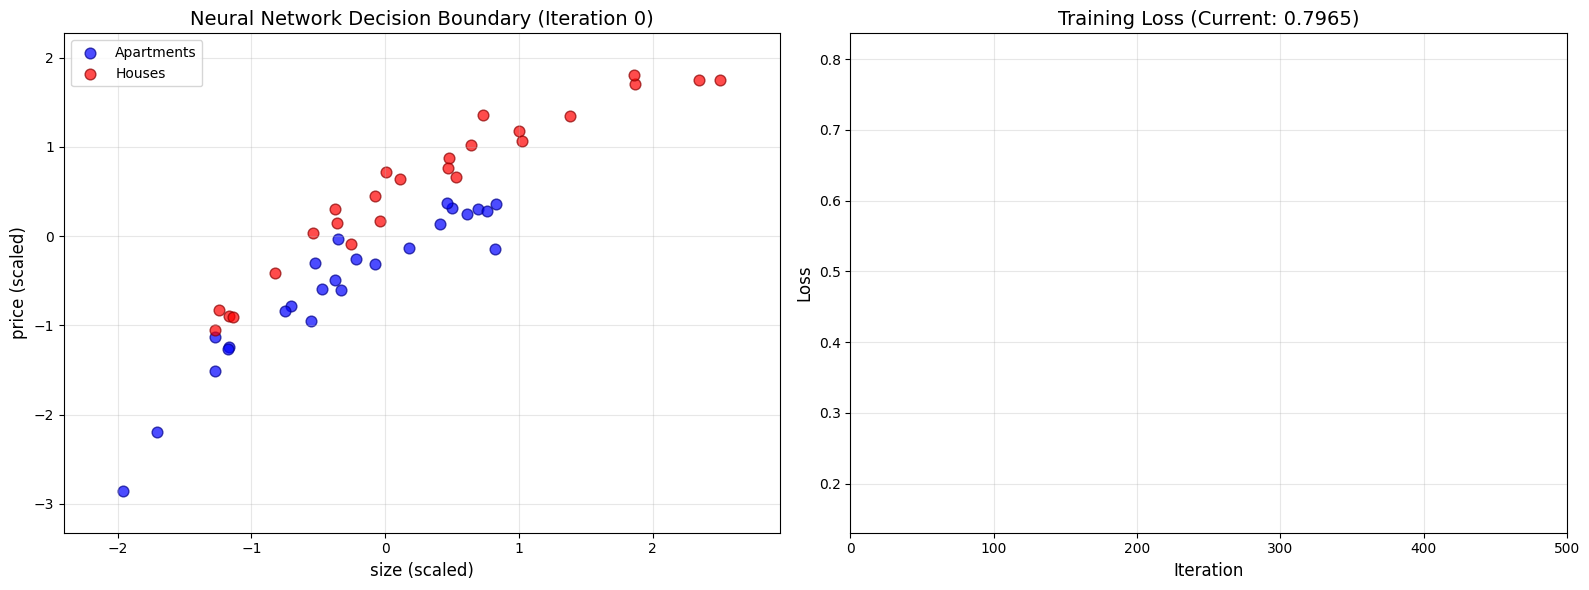

In [11]:
# Train the neural network
nn = SimpleNeuralNetwork(
    input_size=feature_matrix.shape[1], 
    hidden_size=6, 
    output_size=1,
    activation='sigmoid'
)

print("Training Neural Network...")
loss_history, param_history = nn.train(feature_matrix, labels, learning_rate=1.5, n_iterations=500)

# Make predictions
predictions = nn.predict(feature_matrix)

# Calculate accuracy
accuracy = np.mean((predictions > 0.5) == labels)
print(f"\nFinal Training Accuracy: {accuracy:.4f}")

lambdas = []
for params in param_history:
    temp_nn = SimpleNeuralNetwork(
        input_size=feature_matrix.shape[1],
        hidden_size=6,
        output_size=1,
        activation='sigmoid'
    )
    temp_nn.W1 = params['W1']
    temp_nn.b1 = params['b1']
    temp_nn.W2 = params['W2']
    temp_nn.b2 = params['b2']

    lambdas.append(deepcopy(temp_nn.predict))

# Create and display animation
print("\nCreating training animation...")
anim = animate_neural_network(
    feature_matrix, lambdas, labels, loss_history,
    feature_names, plot_every=10,
    # save_path="output/neural_network_training.mp4"
)

from IPython.display import HTML
HTML(anim.to_jshtml())
